Online Judge Platforms is a recommendation system where in the programmer is presented with a question based on his/her expertise.This model will help online judges to decide the next level of questions to recommend to a user.
The goal of this challenge is to predict range of attempts a user will make to solve a given problem given user and problem details.

import the required packages


In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.model_selection import KFold

Read the train and test data

In [47]:
train_problem_data_orig = pd.read_csv("C:/Python/Recommendation_Engine/data/train/problem_data.csv")
train_submission_data_orig = pd.read_csv("C:/Python/Recommendation_Engine/data/train/train_submissions.csv")
train_user_data_orig = pd.read_csv("C:/Python/Recommendation_Engine/data/train/user_data.csv")
test_submission_data_orig = pd.read_csv("C:/Python/Recommendation_Engine/data/test_submissions.csv")

Data Viewing and preprocessing


In [48]:
list(train_problem_data_orig)

['problem_id', 'level_type', 'points', 'tags']

In [49]:
list(train_submission_data_orig)

['user_id', 'problem_id', 'attempts_range']

In [50]:
list(train_user_data_orig)

['user_id',
 'submission_count',
 'problem_solved',
 'contribution',
 'country',
 'follower_count',
 'last_online_time_seconds',
 'max_rating',
 'rating',
 'rank',
 'registration_time_seconds']

In [51]:
list(test_submission_data_orig)

['ID', 'user_id', 'problem_id']

In [52]:
train_problem_data_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6544 entries, 0 to 6543
Data columns (total 4 columns):
problem_id    6544 non-null object
level_type    6411 non-null object
points        2627 non-null float64
tags          3060 non-null object
dtypes: float64(1), object(3)
memory usage: 204.6+ KB


In [53]:
train_problem_data_orig.describe(include='all')

,problem_id,level_type,points,tags
count,6544,6411,2627.000000,3060
unique,6544,14,NaN,882
top,prob_5327,A,NaN,implementation
freq,1,1042,NaN,297
mean,NaN,NaN,1452.381804,NaN
std,NaN,NaN,789.542461,NaN
min,NaN,NaN,-1.000000,NaN
25%,NaN,NaN,1000.000000,NaN
50%,NaN,NaN,1500.000000,NaN
75%,NaN,NaN,2000.000000,NaN


In [54]:
train_problem_data_orig.isnull().sum()

problem_id       0
level_type     133
points        3917
tags          3484
dtype: int64

In [55]:
# The points column had a lot of missing values, based on the values present assuming the points increases by 500 every level
#create dictionary for points
points_dict={"A":500,"B":1000,"C":1500,"D":2000,"E":2500,"F":3000,"G":3500,"H":4000,"I":4500,"J":5000,"K":5500,"L":6000,"M":6500,"N":7000}

In [56]:
train_problem_data = train_problem_data_orig.copy()
#Drop the fields points and tags as more than 50% data are not available
train_problem_data = train_problem_data.drop(['tags'],axis=1)
train_problem_data['level_type'] = train_problem_data['level_type'].fillna('A')

train_problem_data['points'] = list(map(lambda x: points_dict[x],train_problem_data['level_type']))

enc = preprocessing.LabelEncoder()
train_problem_data['level_type'] = enc.fit_transform(train_problem_data['level_type'])

train_problem_data['problem_id'] = list(map(lambda x: int(x.split('_')[1]),train_problem_data['problem_id']))


In [57]:
train_user_data_orig.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3571 entries, 0 to 3570
Data columns (total 11 columns):
user_id                      3571 non-null object
submission_count             3571 non-null int64
problem_solved               3571 non-null int64
contribution                 3571 non-null int64
country                      2418 non-null object
follower_count               3571 non-null int64
last_online_time_seconds     3571 non-null int64
max_rating                   3571 non-null float64
rating                       3571 non-null float64
rank                         3571 non-null object
registration_time_seconds    3571 non-null int64
dtypes: float64(2), int64(6), object(3)
memory usage: 307.0+ KB


In [58]:
#train_user_data_orig.describe(include='all')
train_user_data = train_user_data_orig.copy()
train_user_data = train_user_data.drop(['country','follower_count','last_online_time_seconds','registration_time_seconds'],axis=1)
#train_user_data = train_user_data.drop(['country','follower_count'],axis=1)
train_user_data.describe(include='all')
train_user_data.isnull().sum()

user_id             0
submission_count    0
problem_solved      0
contribution        0
max_rating          0
rating              0
rank                0
dtype: int64

In [59]:
print(train_user_data['rank'].value_counts())
rank_group = train_user_data.groupby('rank')
#print(rank_group.groups)

#for name,group in rank_group:
print (rank_group['problem_solved'].agg(np.mean))
    
    


beginner        1509
intermediate    1410
advanced         570
expert            82
Name: rank, dtype: int64
rank
advanced         543.600000
beginner         117.060305
expert          1042.890244
intermediate     272.792908
Name: problem_solved, dtype: float64


In [60]:

#if contribution is negative change to 0
train_user_data['contribution'] = list(map(lambda x: 0 if (x < 0)  else x,train_user_data['contribution']))
#Check if submission_count >= problem_count
train_user_data['submission_count']=list(map(lambda x,y: y if x < y else x,train_user_data['submission_count'],train_user_data['problem_solved']))
#Encode the categorical varaible rank
rank_encoding = pd.get_dummies(train_user_data['rank'], prefix='rank')
#add the new encoded values to data and remove the categorical field
train_user_data = pd.concat([train_user_data,rank_encoding],axis=1)
train_user_data= train_user_data.drop(['rank'],axis=1)
#remove the prefix user_ from user id and change it to integer
train_user_data['user_id'] = list(map(lambda x: int(x.split('_')[1]),train_user_data['user_id']))

In [61]:
train_submission_data_orig.describe(include='all')

,user_id,problem_id,attempts_range
count,155295,155295,155295.000000
unique,3529,5776,NaN
top,user_1009,prob_5071,NaN
freq,105,1365,NaN
mean,NaN,NaN,1.755028
std,NaN,NaN,1.078450
min,NaN,NaN,1.000000
25%,NaN,NaN,1.000000
50%,NaN,NaN,1.000000
75%,NaN,NaN,2.000000


In [62]:
train_submission_data = train_submission_data_orig.copy()
train_submission_data['problem_id'] = list(map(lambda x: int(x.split('_')[1]),train_submission_data['problem_id']))
train_submission_data['user_id'] = list(map(lambda x: int(x.split('_')[1]),train_submission_data['user_id']))
#train_submission_data.isnull().any(axis=1)

In [63]:
y_train = train_submission_data['attempts_range']
print(y_train)
Y=y_train
train_submission_data = train_submission_data.drop(['attempts_range'],axis =1)

0         1
1         3
2         1
3         1
4         1
5         1
6         1
7         2
8         1
9         1
10        1
11        2
12        1
13        1
14        2
15        2
16        1
17        1
18        1
19        2
20        1
21        2
22        1
23        1
24        1
25        1
26        1
27        4
28        1
29        1
         ..
155265    1
155266    1
155267    1
155268    2
155269    2
155270    2
155271    4
155272    1
155273    1
155274    2
155275    1
155276    3
155277    1
155278    1
155279    1
155280    1
155281    1
155282    1
155283    1
155284    1
155285    1
155286    1
155287    2
155288    1
155289    2
155290    1
155291    6
155292    1
155293    2
155294    2
Name: attempts_range, Length: 155295, dtype: int64


Merge the three training tables to form one singular table

In [64]:
merge_train = pd.merge(train_submission_data,train_user_data,how="inner",left_on='user_id',right_on='user_id')
merge_train = pd.merge(merge_train,train_problem_data,how="inner",left_on='problem_id',right_on='problem_id')
merge_train['error_submission'] = np.abs(merge_train['problem_solved'] - merge_train['submission_count'])
#merge_train['rating-diff'] = np.abs(merge_train['max_rating'] - merge_train['rating'])
merge_train['level_type'] = merge_train['level_type'] * merge_train['points']
#merge_train = merge_train.drop(['problem_solved','submission_count'],axis=1)
print(merge_train.shape)
merge_train.info()
merge_train.head()

(155295, 14)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 155295 entries, 0 to 155294
Data columns (total 14 columns):
user_id              155295 non-null int64
problem_id           155295 non-null int64
submission_count     155295 non-null int64
problem_solved       155295 non-null int64
contribution         155295 non-null int64
max_rating           155295 non-null float64
rating               155295 non-null float64
rank_advanced        155295 non-null uint8
rank_beginner        155295 non-null uint8
rank_expert          155295 non-null uint8
rank_intermediate    155295 non-null uint8
level_type           155295 non-null int64
points               155295 non-null int64
error_submission     155295 non-null int64
dtypes: float64(2), int64(8), uint8(4)
memory usage: 13.6 MB


,user_id,problem_id,submission_count,problem_solved,contribution,max_rating,rating,rank_advanced,rank_beginner,rank_expert,rank_intermediate,level_type,points,error_submission
0,232,6507,53,47,0,307.913,206.709,0,1,0,0,1000,1000,6
1,1910,6507,240,218,0,319.954,291.284,0,1,0,0,1000,1000,22
2,1824,6507,370,336,0,307.339,295.585,0,1,0,0,1000,1000,34
3,895,6507,318,286,0,304.186,191.514,0,1,0,0,1000,1000,32
4,779,6507,463,410,0,374.713,374.713,0,0,0,1,1000,1000,53


Processing test data


In [65]:
print(test_submission_data_orig.shape)
list(test_submission_data_orig)
test_submission_data = test_submission_data_orig.copy()
test_id = pd.DataFrame(test_submission_data['ID'])
test_submission_data = test_submission_data.drop(['ID'],axis=1)
list(test_submission_data)
test_submission_data['problem_id'] = list(map(lambda x: int(x.split('_')[1]),test_submission_data['problem_id']))
test_submission_data['user_id'] = list(map(lambda x: int(x.split('_')[1]),test_submission_data['user_id']))

(66555, 3)


In [66]:
merge_test = pd.merge(test_submission_data,train_user_data,how="inner",left_on='user_id',right_on='user_id')
merge_test = pd.merge(merge_test,train_problem_data,how="inner",left_on='problem_id',right_on='problem_id') 
merge_test['error_submission'] = np.abs(merge_test['problem_solved'] - merge_test['submission_count'])
#merge_test['rating-diff'] = np.abs(merge_test['max_rating'] - merge_test['rating'])
merge_test['level_type'] = (merge_test['level_type'] * merge_test['points'])
#merge_test = merge_test.drop(['problem_solved','submission_count'],axis=1)

In [67]:
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(merge_train,y_train)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(merge_train.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(10,'Score'))  #print 10 best features

               Specs          Score
11        level_type  109376.278590
1         problem_id    8543.237300
0            user_id    5366.172983
3     problem_solved    3764.117865
2   submission_count    3679.564019
12            points    1831.788853
4       contribution     314.697116
6             rating     274.891839
5         max_rating     153.548899
13  error_submission     137.610719


In [68]:
merge_train = merge_train.drop(['max_rating','rating','contribution','points'],axis=1)
merge_test = merge_test.drop(['max_rating','rating','contribution','points'],axis=1)
merge_train.info()
merge_test.info()
X=merge_train

<class 'pandas.core.frame.DataFrame'>
Int64Index: 155295 entries, 0 to 155294
Data columns (total 10 columns):
user_id              155295 non-null int64
problem_id           155295 non-null int64
submission_count     155295 non-null int64
problem_solved       155295 non-null int64
rank_advanced        155295 non-null uint8
rank_beginner        155295 non-null uint8
rank_expert          155295 non-null uint8
rank_intermediate    155295 non-null uint8
level_type           155295 non-null int64
error_submission     155295 non-null int64
dtypes: int64(6), uint8(4)
memory usage: 8.9 MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 66555 entries, 0 to 66554
Data columns (total 10 columns):
user_id              66555 non-null int64
problem_id           66555 non-null int64
submission_count     66555 non-null int64
problem_solved       66555 non-null int64
rank_advanced        66555 non-null uint8
rank_beginner        66555 non-null uint8
rank_expert          66555 non-null uint8
rank_int

In [69]:
# Feature Scaling
scaler = StandardScaler()
merge_train = scaler.fit_transform(merge_train)
merge_test = scaler.fit_transform(merge_test)
print(merge_train)

[[-1.50676836  1.70430221 -0.80168947 ... -0.86551316 -0.29217164
  -0.92101471]
 [ 0.12849615  1.70430221 -0.33208052 ... -0.86551316 -0.29217164
  -0.4323639 ]
 [ 0.04468641  1.70430221 -0.00561441 ... -0.86551316 -0.29217164
  -0.06587578]
 ...
 [-1.02340055  0.89968096 -0.63092258 ...  1.15538394 -0.40999795
  -0.92101471]
 [ 0.48225122 -0.2692086   0.06470136 ...  1.15538394  2.06435473
   0.8503445 ]
 [-1.22805224 -0.52299782 -0.86698269 ... -0.86551316  1.35739682
  -0.82939269]]


C:\Users\Srividya\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Srividya\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Srividya\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Srividya\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [70]:
x_train, x_cv, y_train, y_cv = train_test_split(merge_train,y_train, test_size =0.4)

In [26]:
'''model = LogisticRegression(multi_class='multinomial',solver='newton-cg',max_iter=500)
model.fit(x_train, y_train)

pred_cv = model.predict(x_cv)
print(pred_cv)
print('F1 Score is',f1_score(y_cv,pred_cv,average='micro'))
#make predictions on the test data
pred = model.predict(merge_test)
submission = pd.DataFrame({
        "ID": test_submission_data_orig['ID'],
        "attempts_range": pred
    })
submission.to_csv('C:/Python/Recommendation_Engine/data/RE_LogReg_submission.csv.csv', index=False)
'''

'model = LogisticRegression(multi_class=\'multinomial\',solver=\'newton-cg\',max_iter=500)\nmodel.fit(x_train, y_train)\n\npred_cv = model.predict(x_cv)\nprint(pred_cv)\nprint(\'F1 Score is\',f1_score(y_cv,pred_cv,average=\'micro\'))\n#make predictions on the test data\npred = model.predict(merge_test)\nsubmission = pd.DataFrame({\n        "ID": test_submission_data_orig[\'ID\'],\n        "attempts_range": pred\n    })\nsubmission.to_csv(\'C:/Python/Recommendation_Engine/data/RE_LogReg_submission.csv.csv\', index=False)\n'

In [27]:
# Fitting Random Forest Classification to the Training set

#kf = KFold(n_splits=5)
model = RandomForestClassifier(n_estimators =150, criterion = 'gini',max_features=7)
model.fit(x_train, y_train)
pred_cv = model.predict(x_cv)
print(pred_cv)
print('F1 Score is',f1_score(y_cv,pred_cv,average='weighted'))
#make predictions on the test data
pred = model.predict(merge_test)
submission = pd.DataFrame({
        "ID": test_submission_data_orig['ID'],
        "attempts_range": pred
    })
submission.to_csv('C:/Python/Recommendation_Engine/data/RE_RdForest_submission.csv.csv', index=False)

[1 1 2 ... 1 1 1]
F1 Score is 0.41254474405534197


[0.13383372 0.43267467 0.09771902 0.09850658 0.00950222 0.01078888
 0.00255843 0.01323755 0.10460802 0.0965709 ]


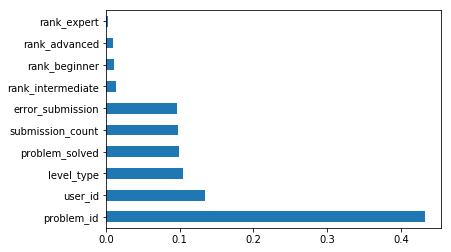

In [28]:
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

In [40]:
print(list(zip(merge_train, model.feature_importances_)))
#joblib.dump(model, 'randomforestmodel.pkl') 

[(array([-1.50676836,  1.70430221, -0.80168947, -0.76602035, -0.49286593,
        1.38538747, -0.18683344, -0.86551316, -0.29217164, -0.22579481,
       -0.92101471]), 0.12893844057075893), (array([ 0.12849615,  1.70430221, -0.33208052, -0.31289294, -0.49286593,
        1.38538747, -0.18683344, -0.86551316, -0.29217164, -0.22579481,
       -0.4323639 ]), 0.437828581246283), (array([ 4.46864054e-02,  1.70430221e+00, -5.61441468e-03, -2.08532377e-04,
       -4.92865932e-01,  1.38538747e+00, -1.86833443e-01, -8.65513158e-01,
       -2.92171636e-01, -2.25794815e-01, -6.58757831e-02]), 0.09657444980852278), (array([-0.86065372,  1.70430221, -0.13620086, -0.13270193, -0.49286593,
        1.38538747, -0.18683344, -0.86551316, -0.29217164, -0.22579481,
       -0.12695714]), 0.09693363851649475), (array([-0.97369942,  1.70430221,  0.22793442,  0.19588169, -0.49286593,
       -0.72181972, -0.18683344,  1.15538394, -0.29217164, -0.22579481,
        0.51439706]), 0.00916388669387664), (array([ 0.4

In [ ]:
'''from sklearn.ensemble import AdaBoostClassifier
model = AdaBoostClassifier(n_estimators=100, base_estimator=dt,learning_rate=1) 
model.fit(x_train, y_train)
pred_cv = clf.predict(x_cv)
print(pred_cv)
print('F1 Score is',f1_score(y_cv,pred_cv,average='micro'))
#make predictions on the test data
pred = model.predict(merge_test)
submission = pd.DataFrame({
        "ID": test_submission_data_orig['ID'],
        "attempts_range": pred
    })
submission.to_csv('C:/Python/Recommendation_Engine/data/RE_AdaBoost_submission.csv.csv', index=False)
'''

In [29]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier()
model.fit(x_train, y_train)
pred_cv = model.predict(x_cv)
print(pred_cv)
print('F1 Score is',f1_score(y_cv,pred_cv,average='micro'))
#make predictions on the test data
pred = model.predict(merge_test)
submission = pd.DataFrame({
        "ID": test_submission_data_orig['ID'],
        "attempts_range": pred
    })
submission.to_csv('C:/Python/Recommendation_Engine/data/RE_DecTree_submission.csv.csv', index=False)


[1 1 1 ... 1 2 3]
F1 Score is 0.3823046459963296


In [ ]:
'''import xgboost as xgb
model=xgb.XGBClassifier(random_state=1,learning_rate=0.01)
model.fit(x_train, y_train)
pred_cv = model.predict(x_cv)
print(pred_cv)
#print('F1 Score is',f1_score(y_cv,pred_cv,average='weighted'))
#make predictions on the test data
pred = model.predict(merge_test)
submission = pd.DataFrame({
        "ID": test_submission_data_orig['ID'],
        "attempts_range": pred
    })
submission.to_csv('C:/Python/Recommendation_Engine/data/RE_XGBoost_submission.csv.csv', index=False)
best_f_score = do_train(param, dtrain,'train',trainY,dtest,'test',testY)
'''

In [74]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=6).fit(X)
print(kmeans.labels_)
print(kmeans.cluster_centers_)
#plt.scatter(x=X['user_id'],y=y_train,c=kmeans.labels_)

[3 3 3 ... 3 2 2]
[[1.78542661e+03 1.51962894e+03 3.17227704e+02 2.83954919e+02
  1.46961992e-01 4.04980768e-01 1.92809179e-02 4.28776322e-01
  9.34953387e+02 3.32727851e+01]
 [1.78680029e+03 3.13530048e+03 6.33024551e+02 5.79135581e+02
  3.74496152e-01 1.35580799e-01 8.68449982e-02 4.03078051e-01
  4.46317332e+04 5.38889703e+01]
 [1.76970888e+03 3.27581371e+03 6.36337891e+02 5.84173603e+02
  4.10225922e-01 1.14546175e-01 1.15933413e-01 3.59294491e-01
  1.98862465e+04 5.21642885e+01]
 [1.77744521e+03 4.86814013e+03 3.40257349e+02 3.05665119e+02
  1.59428283e-01 3.83580741e-01 2.27798459e-02 4.34211131e-01
  9.29607672e+02 3.45922300e+01]
 [1.75968110e+03 3.17470634e+03 5.32337193e+02 4.89369745e+02
  3.74813637e-01 1.11768214e-01 8.33913130e-02 4.30026836e-01
  7.23188550e+03 4.29674486e+01]
 [1.76443137e+03 3.45443268e+03 6.29233987e+02 5.76211765e+02
  3.83006536e-01 1.46405229e-01 8.88888889e-02 3.81699346e-01
  7.14562092e+04 5.30222222e+01]]


In [83]:
from sklearn.decomposition import PCA
pca = PCA(n_components=1).fit(X)
Y=Y.reshape(2,1)
pca_d = pca.transform(Y)

pca_c = pca.transform(X)

plt.figure('3 Cluster K-Means')

plt.scatter(pca_c[:, 0], pca_d[:, 0], c=kmeans.labels_)

plt.xlabel('user Problem ID')

plt.ylabel('Atempts')

plt.title('3 Cluster K-Means')

plt.show()

ValueError: cannot reshape array of size 155295 into shape (2,1)

In [ ]:
# y = np.array(y_train)
# correct = 0
# for i in range(len(merge_train)):
#     predict_me = np.array(merge_train[i].astype(float))
#     predict_me = predict_me.reshape(-1, len(predict_me))
#     prediction = kmeans.predict(predict_me)
    
# #     if prediction[0] == y[i]:
# #         correct += 1
# print(len(prediction))
# print(correct/len(X))